In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import shared.utils as su

### Load data

In [8]:
from notebooks.eval_care_retrieval import load_data, load_model

dataset = 'charades'
df = load_data(dataset)
df.shape

Number of rows:  5498
Sample row: 
{
    "id_base": "YSKX3",
    "subject": "CP6Y",
    "scene": "Bedroom",
    "quality": 5.0,
    "relevance": 6.0,
    "verified": "Yes",
    "length": 16.62,
    "cls_id": "c077",
    "template": "putting a pillow somewhere",
    "start_time": 12.1,
    "end_time": 16.62,
    "object_id": "o027",
    "noun": "na",
    "verb_id": "v016",
    "verb": "put",
    "label": "putting a pillow somewhere",
    "id": "YSKX3_12.1_16.6",
    "chiral_label": 0.0,
    "chiral_triplet_id": "a9be73ec",
    "text_id": "a9be73ec_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/YSKX3_12.1_16.6.mp4"
}


(5498, 21)

In [9]:
!ls /work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint/embs/

texts_feat-charades.pt	texts_feat-ssv2.pt	video_feat-epic.pt
texts_feat-epic.pt	video_feat-charades.pt	video_feat-ssv2.pt


In [10]:
!ls /work/piyush/pretrained_checkpoints/Tarsier-7b/embs/

texts_feat-charades.pt	texts_feat-ssv2.pt	video_feat-epic.pt
texts_feat-epic.pt	video_feat-charades.pt	video_feat-ssv2.pt


In [11]:
!ls /work/piyush/pretrained_checkpoints/CaRe-7B/embs

texts_feat-epic.pt  texts_feat-ssv2.pt	video_feat-epic.pt  video_feat-ssv2.pt


### Load results

In [12]:
df.iloc[0]

id_base                                                          YSKX3
subject                                                           CP6Y
scene                                                          Bedroom
quality                                                            5.0
relevance                                                          6.0
verified                                                           Yes
length                                                           16.62
cls_id                                                            c077
template                                    putting a pillow somewhere
start_time                                                        12.1
end_time                                                         16.62
object_id                                                         o027
noun                                                                na
verb_id                                                           v016
verb  

In [13]:
adap_dir = "/work/piyush/experiments/CaRe/Tarsier-7b/final-10112025/nli_9000+ego_1000+subj_replaced-seed_42/merged_checkpoint/embs/"
base_dir = "/work/piyush/pretrained_checkpoints/Tarsier-7b/embs/"

base_video_embs = torch.load(f"{base_dir}/video_feat-{dataset}.pt")
base_texts_embs = torch.load(f"{base_dir}/texts_feat-{dataset}.pt")

adap_video_embs = torch.load(f"{adap_dir}/video_feat-{dataset}.pt")
adap_texts_embs = torch.load(f"{adap_dir}/texts_feat-{dataset}.pt")

In [14]:
triplet_ids = df.chiral_triplet_id.unique()
len(triplet_ids)

28

In [16]:
text_col = 'template'

In [17]:
# Pick a random triplet ID
chiral_triplet_id = np.random.choice(triplet_ids)

df_pos = df[(df.chiral_triplet_id == chiral_triplet_id) & (df.chiral_label == 1.)]
video_ids_pos = df_pos.id.values
video_paths_pos = df_pos.video_path.values
text_pos = df_pos[text_col].iloc[0]

df_neg = df[(df.chiral_triplet_id == chiral_triplet_id) & (df.chiral_label == 0.)]
video_ids_neg = df_neg.id.values
video_paths_neg = df_neg.video_path.values
text_neg = df_neg[text_col].iloc[0]

noun = df_neg.noun.iloc[0]

len(video_ids_pos), len(video_ids_neg), text_pos, text_neg, noun

(6, 209, 'standing on a chair', 'sitting in a chair', 'na')

In [18]:
video_id_to_target = dict(zip(df['id'], df[text_col]))

In [19]:
def generate_retrieval_result(text_embeds, video_embeds, chiral_triplet_id, topk=3):

    # Positives
    df_pos = df[(df.chiral_triplet_id == chiral_triplet_id) & (df.chiral_label == 1.)]
    video_ids_pos = df_pos.id.values
    video_paths_pos = df_pos.video_path.values
    text_pos = df_pos[text_col].iloc[0]

    # Negatives
    df_neg = df[(df.chiral_triplet_id == chiral_triplet_id) & (df.chiral_label == 0.)]
    video_ids_neg = df_neg.id.values
    video_paths_neg = df_neg.video_path.values
    text_neg = df_neg[text_col].iloc[0]
    
    noun = df_neg.noun.iloc[0]

    # Perform t2v with positive class query
    ret = {}
    for query, target in zip([text_pos, text_neg], [1.0, 0.0]):
        query_emb = text_embeds[f"{chiral_triplet_id}_{target}"]
        video_ids = list(video_ids_pos) + list(video_ids_neg)
        video_paths = list(video_paths_pos) + list(video_paths_neg)
        candidate_emb = torch.stack([video_embeds[x] for x in video_ids])
        sim = query_emb @ candidate_emb.T
        ranked_video_indices = torch.argsort(-sim)[:topk]
        ranked_video_ids = np.array(video_ids)[ranked_video_indices]
        ranked_video_paths = np.array(video_paths)[ranked_video_indices]
        ranked_labels = [video_id_to_target[x] for x in ranked_video_ids]
        is_correct = [int(l == query) for l in ranked_labels]
        ret[query] = {
            'ranked_video_paths': list(ranked_video_paths),
            'ranked_texts': list(ranked_labels),
            'is_correct': is_correct,
        }

    outputs = {
        'noun': noun,
        'text_pos': text_pos,
        'text_neg': text_neg,
        'retrieval': ret,
    }
    return outputs

In [20]:
base_results = generate_retrieval_result(
    base_texts_embs, base_video_embs, chiral_triplet_id,
)
base_results

{'noun': 'na',
 'text_pos': 'standing on a chair',
 'text_neg': 'sitting in a chair',
 'retrieval': {'standing on a chair': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/XOOPP_6.5_17.2.mp4'),
    np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/1NJOQ_11.3_35.0.mp4'),
    np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/W1CG2_2.6_21.3.mp4')],
   'ranked_texts': ['standing on a chair',
    'sitting in a chair',
    'sitting in a chair'],
   'is_correct': [1, 0, 0]},
  'sitting in a chair': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/E6DLK_3.1_11.8.mp4'),
    np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/FTYFA_14.9_30.4.mp4'),
    np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/JZULS_0.0_27.4.mp4')],
   'ranked_texts': ['sitting 

In [21]:
base_results_all = {}
adap_results_all = {}
for chiral_triplet_id in su.log.tqdm_iterator(triplet_ids, desc='Collecting results'):
    base_results_all[chiral_triplet_id] = generate_retrieval_result(
        base_texts_embs, base_video_embs, chiral_triplet_id,
    )
    adap_results_all[chiral_triplet_id] = generate_retrieval_result(
        adap_texts_embs, adap_video_embs, chiral_triplet_id,
    )
len(base_results_all), len(adap_results_all)

(28, 28)

In [22]:
def show_retrieval_samples(video_paths: list, query: str, retrieved: list, nframes=2, return_frames=False, k=-1):
    
    frames = [
        su.visualize.concat_images_with_border(
            su.video.load_frames_linspace(f, n=nframes, width=256, height=224)
        ) for f in video_paths[:k]
    ]
    colors = [
        'limegreen' if query == retrieved[i] else 'red' for i in range(len(retrieved[:k]))
    ]
    frames = [su.visualize.add_frame_around_image(f, c, thickness=7) for f, c in zip(frames, colors)]
    if return_frames:
        return frames
    # canvas = su.visualize.concat_images_vertically_with_border(frames)
    image = su.visualize.show_grid_of_images(
        images=frames,
        n_cols=1,
        subtitles=retrieved,
        return_as_pil=True,
        show=False,
        # figsize=(4, 6),
        figsize=(4, 4),
        subtitlesize=11,
    )
    return image

d6b51007
{'noun': 'na', 'text_pos': 'taking a laptop from somewhere', 'text_neg': 'putting a laptop somewhere', 'retrieval': {'taking a laptop from somewhere': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/YZ8HK_7.4_15.1.mp4'), np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/AB2V6_16.9_22.9.mp4'), np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/VQOI3_13.8_17.8.mp4')], 'ranked_texts': ['putting a laptop somewhere', 'taking a laptop from somewhere', 'putting a laptop somewhere'], 'is_correct': [0, 1, 0]}, 'putting a laptop somewhere': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/YZ8HK_7.4_15.1.mp4'), np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/TYWHY_11.3_16.6.mp4'), np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/9KDP0_22.9_3

taking a laptop from somewhere

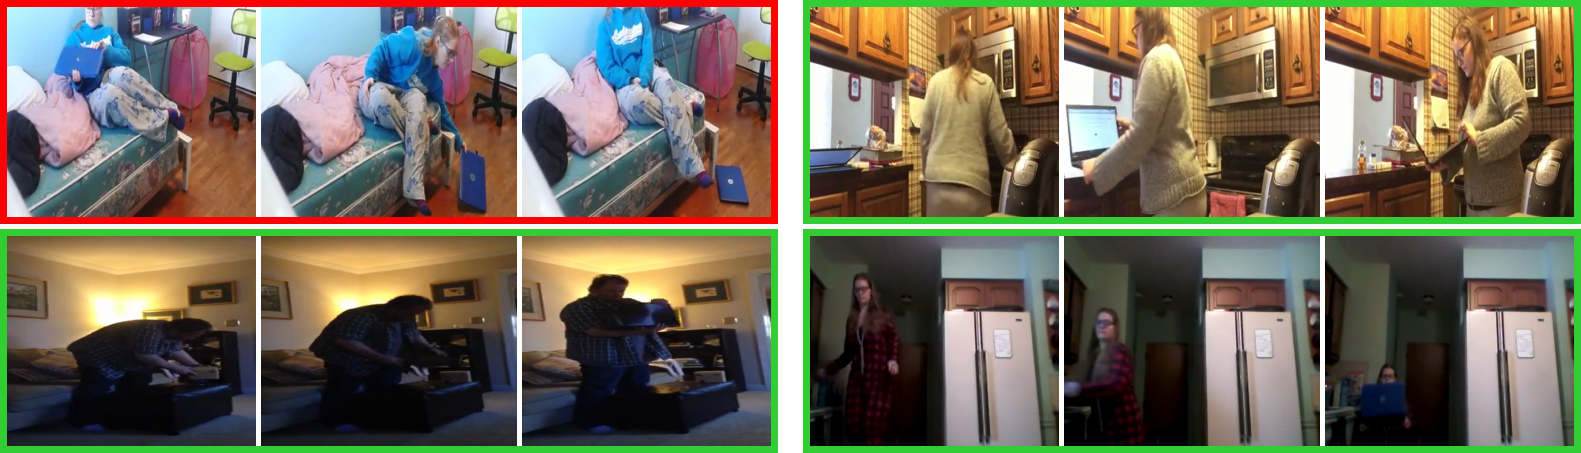

In [44]:
# chiral_triplet_id = 'b58b2f93'
# chiral_triplet_id = 'a1383a77'
# chiral_triplet_id = 'edebebd4'
# chiral_triplet_id = '106d2603'
# chiral_triplet_id = 'ccff0ef2'

# chiral_triplet_id = '7c681a61' # EPIC


chiral_triplet_id = np.random.choice(triplet_ids)
chiral_triplet_id = 'd6b51007'
print(chiral_triplet_id)

# print(json.dumps(base_results_all[chiral_triplet_id], indent=2))
# print("_" * 100)
# print(json.dumps(adap_results_all[chiral_triplet_id], indent=2))

print(base_results_all[chiral_triplet_id])
print("_" * 100)
print(adap_results_all[chiral_triplet_id])

show = True
if show:
    keys = list(base_results_all[chiral_triplet_id]['retrieval'].keys())
    query = keys[0]
    frames = show_retrieval_samples(
        base_results_all[chiral_triplet_id]['retrieval'][query]['ranked_video_paths'],
        query,
        base_results_all[chiral_triplet_id]['retrieval'][query]['ranked_texts'],
        nframes=3,
        return_frames=True,
        k=2,
    )
    canvas_base = su.visualize.concat_images_vertically_with_border(frames)
    
    frames = show_retrieval_samples(
        adap_results_all[chiral_triplet_id]['retrieval'][query]['ranked_video_paths'],
        query,
        adap_results_all[chiral_triplet_id]['retrieval'][query]['ranked_texts'],
        nframes=3,
        return_frames=True,
        k=2,
    )
    canvas_adap = su.visualize.concat_images_vertically_with_border(frames)

    canvas = su.visualize.concat_images_with_border(
        [canvas_base, canvas_adap], border_width=25
    )

    display(Markdown(query))
    display(canvas)

In [45]:
canvas.save('image.png')

In [42]:
base_results_all

{'a9be73ec': {'noun': 'na',
  'text_pos': 'taking a pillow from somewhere',
  'text_neg': 'putting a pillow somewhere',
  'retrieval': {'taking a pillow from somewhere': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/CLB72_15.6_23.7.mp4'),
     np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/D6J8Q_13.9_23.4.mp4'),
     np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/Y0MCG_0.0_3.4.mp4')],
    'ranked_texts': ['taking a pillow from somewhere',
     'taking a pillow from somewhere',
     'taking a pillow from somewhere'],
    'is_correct': [1, 1, 1]},
   'putting a pillow somewhere': {'ranked_video_paths': [np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/Y0MCG_4.9_10.8.mp4'),
     np.str_('/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/ITDHX_18.2_26.1.mp4'),
     np.str_('/scratch/shared/beegfs/piyus